In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightning as L
import torchaudio.transforms as T
from transformers import Wav2Vec2Model
from module.KAN import KAN
from metrix.LM import LandmarkDistance, LandmarkVelocityDifference
import torchaudio


/mnt/e/ws/2024/S2T/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import torchaudio.transforms as T


class MEAD(Dataset):
    def __init__(self, data_path, duration, batch):
        super(MEAD, self).__init__()

        with open(data_path,"r") as f:
            datalist = json.load(f)
        ln = int(len(datalist)/batch)*batch
        self.datalist = datalist[:ln]
        self.time = duration

        self.mn = 56
        self.mx = 243



    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, idx):
        row = self.datalist[idx]

        waveform, sample_rate = torchaudio.load(f"dataset/duration/audios/{row['audio']}", num_frames= 48000* self.time, normalize="True")
        landmark =  torch.from_numpy(np.load(f"dataset/duration/fa_landmarks/{row['landmark']}")).permute(0,2,1)[:30*self.time]
        landmark = (landmark - self.mn) / (self.mx - self.mn)
        # ilm = torch.mean(landmark, dim=1)
        name = row["name"].split('_')[0]
        ilm = landmark[0]
        waveform = T.Resample(48000, 16000, dtype=waveform.dtype)(waveform)
        waveform = torch.mean(waveform, dim=0)

        # waveform = torch.load(f"dataset/vec2s/M003_front_{row['name']}.pt")

        return {'name': row['name'], 'audio':waveform.float(), 'target':landmark.float(), 'ilm':ilm.float(), 'label':row['emotion']}

In [74]:
datas = MEAD("dataset/duration/fa_datalist.json", duration=1, batch=16)

In [75]:
loader = DataLoader(datas, batch_size=1, shuffle=True)

In [77]:
30/7

4.285714285714286

['W035_sad_level_1_020']


TypeError: cannot unpack non-iterable Axes object

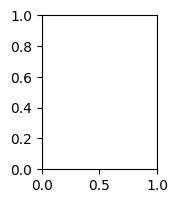

In [86]:
import torchvision
k = 0
for item in loader:
    print(item['name'])

    plt.figure(figsize=(14,2))
    plt.plot(item['audio'][0])
    plt.savefig(f"temp/datashow/aud_{item['name'][0]}.png")

    plt.close()

    name = item['name'][0].split("_",1)
    video = torchvision.io.read_video(f"dataset/duration/vidcrops/{name[0]}_front_{name[1]}.mp4", pts_unit='sec')[0]
    i = 0


    item['target'] = item['target'] * (datas.mx - datas.mn) + datas.mn
    plt.figure(figsize=(14,2))
    for sid in range(1,30,4):
        plt, ax = plt.subplot(1,8,i+1)
        i += 1
        plt.imshow(video[sid])
        # plt.axis('off') 
        ax.set_xstick([])
        ax.set_ystick([])
    plt.savefig(f"temp/datashow/face_{item['name'][0]}.png")

    plt.close()
    i = 0

    plt.figure(figsize=(14,2))
    for sid in range(1,30,4):
        plt, ax = plt.subplot(1,8,i+1)
        plain = np.ones((256,256,3))
        plt.imshow(plain)
        plt.scatter(item['target'][0][sid][0,:], item['target'][0][sid][1,:], c='b', s=0.5)
        # plt.axis('off') 
        i+=1
    plt.savefig(f"temp/datashow/lmd_{item['name'][0]}.png")
    plt.close()
    break

    if k == 10: break
    else: k+= 1

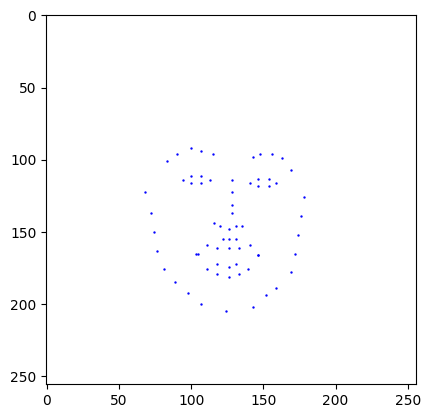

In [50]:
plain = np.ones((256,256,3))
item['target'] = item['target'] * (datas.mx - datas.mn) + datas.mn
plt.imshow(plain)
plt.scatter(item['target'][0][sid][0,:], item['target'][0][sid][1,:], c='b', s=0.5)

In [48]:
 item['target'][0][sid][1,:]

tensor([0.3529, 0.4332, 0.5027, 0.5722, 0.6417, 0.6898, 0.7273, 0.7701, 0.7968,
        0.7807, 0.7380, 0.7112, 0.6524, 0.5829, 0.5134, 0.4439, 0.3743, 0.2406,
        0.2139, 0.1925, 0.2032, 0.2139, 0.2246, 0.2139, 0.2139, 0.2299, 0.2727,
        0.3102, 0.3529, 0.4011, 0.4332, 0.4706, 0.4813, 0.4920, 0.4813, 0.4813,
        0.3102, 0.2941, 0.2941, 0.3102, 0.3209, 0.3209, 0.3209, 0.3048, 0.3048,
        0.3209, 0.3316, 0.3316, 0.5829, 0.5508, 0.5294, 0.5294, 0.5294, 0.5508,
        0.5882, 0.6417, 0.6578, 0.6684, 0.6578, 0.6417, 0.5829, 0.5615, 0.5615,
        0.5615, 0.5882, 0.6203, 0.6310, 0.6203])

In [1]:
import os
import face_alignment
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage


img_list = os.listdir("quality_compair/output")

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cuda')

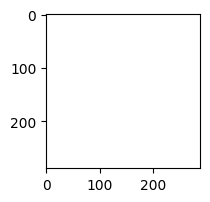

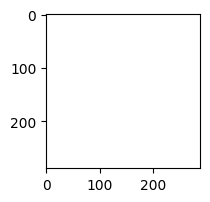

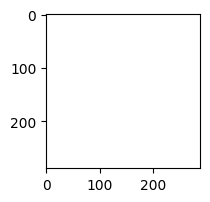

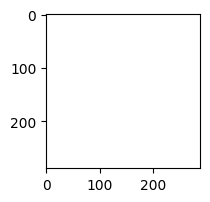

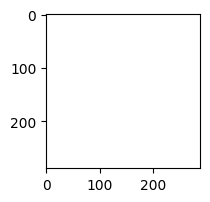

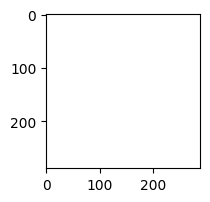

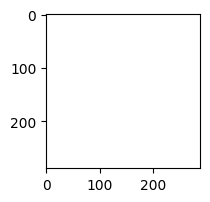

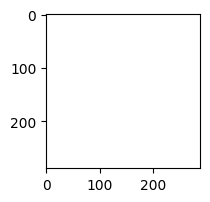

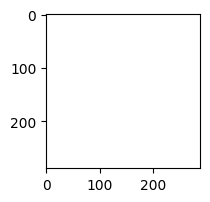

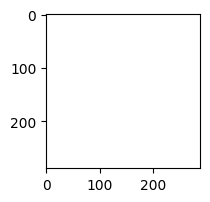

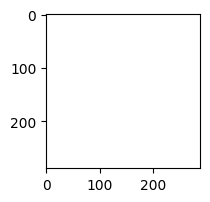

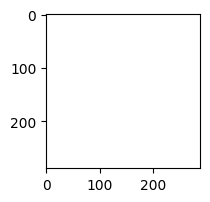

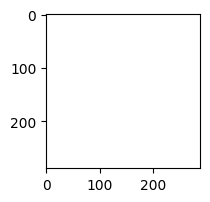

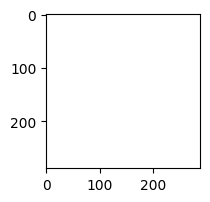

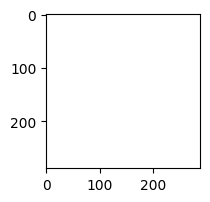

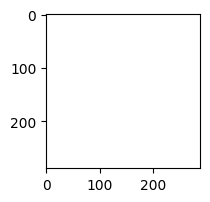

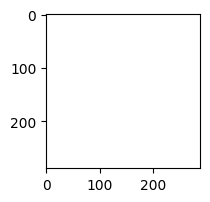

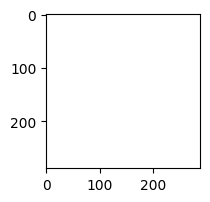

In [69]:
for name in img_list:
    img = io.imread(f"quality_compair/output/{name}")[:,:,:3]
    # img = skimage.transform.resize(img, (256, 256, 3))
    lmd = fa.get_landmarks(img)
    np.save(f"quality_compair/landmarks/{name.replace('.png','')}.npy", lmd)
    plain = np.ones((288, 288, 3))
    plt.figure(figsize=(2,2))
    plt.imshow(plain)

    if "GT" in name: 
        c='b'
        lmd = lmd[0] 
        lmd = lmd + np.random.uniform(-1,1 , [68,2])
        plt.plot(lmd[0:17,0],lmd[0:17,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[17:22,0],lmd[17:22,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[22:27,0],lmd[22:27,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[27:31,0],lmd[27:31,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[31:36,0],lmd[31:36,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[36:42,0],lmd[36:42,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[42:48,0],lmd[42:48,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[48:60,0],lmd[48:60,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3)
        plt.plot(lmd[60:68,0],lmd[60:68,1],marker='o',markersize=0.5, linestyle='-',color=c,lw=0.3) 
        plt.savefig(f"quality_compair/show/_{name}")
        plt.close()


In [62]:
lmd

[array([[ 73., 129.],
        [ 75., 147.],
        [ 80., 162.],
        [ 83., 177.],
        [ 88., 193.],
        [ 98., 208.],
        [108., 218.],
        [123., 230.],
        [146., 238.],
        [166., 230.],
        [176., 220.],
        [186., 210.],
        [194., 198.],
        [201., 180.],
        [204., 165.],
        [206., 147.],
        [206., 132.],
        [ 90., 112.],
        [ 98., 104.],
        [110., 102.],
        [121., 102.],
        [128., 104.],
        [163., 107.],
        [171., 104.],
        [181., 104.],
        [191., 107.],
        [199., 112.],
        [146., 124.],
        [148., 134.],
        [148., 145.],
        [148., 155.],
        [133., 160.],
        [138., 162.],
        [146., 165.],
        [153., 162.],
        [158., 162.],
        [103., 124.],
        [110., 119.],
        [118., 119.],
        [126., 124.],
        [121., 127.],
        [110., 127.],
        [163., 124.],
        [171., 122.],
        [179., 122.],
        [1

In [64]:
b

array([[ 73.79872794, 110.97756771],
       [ 54.86100197, 155.8631797 ],
       [ 89.09683293, 203.38054015],
       [120.3054312 , 221.29574145],
       [ 53.72582591, 182.09564803],
       [127.20636289, 192.86183017],
       [ 92.69139034, 192.72748347],
       [134.79121499, 259.38062062],
       [155.49122048, 216.06951778],
       [120.1574452 , 256.95346156],
       [198.59897955, 213.78202159],
       [177.73659811, 226.47293117],
       [200.14856206, 240.73302132],
       [230.95441179, 164.92415233],
       [243.77637733, 193.19307197],
       [242.78132737, 156.39509076],
       [173.67971471, 159.7384791 ],
       [ 48.2091147 , 129.85339332],
       [ 78.22628747,  68.54890278],
       [132.3107515 , 141.47217978],
       [102.50632309, 134.63520116],
       [ 88.96918491, 151.94294566],
       [201.92920421, 146.40196654],
       [121.61694471,  56.45852871],
       [203.91044993, 123.59955914],
       [219.61691216, 117.86123212],
       [240.62815852, 154.52226725],
 